In [1]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import multivariate_normal
from keras.optimizers import Adam, SGD, Adadelta



In [2]:
x_train_scaled = pd.read_csv('../260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,0.702813,0.799052,0.719665,0.729547,0.794953,0.256451,1.000000,0.363133,0.374212,0.611161,...,0.468042,0.335792,0.0,0.609518,0.535456,0.0,0.543158,0.622641,0.0,1.0
168_CD_plain,0.751408,0.603707,0.622768,0.627712,0.606860,0.520576,0.311962,0.251356,0.553554,0.441131,...,0.000000,0.159464,0.0,0.173529,0.018188,0.0,0.623796,0.301179,0.0,0.0
72_control,0.786508,0.755331,0.739605,0.756170,0.819875,0.391132,0.648401,0.134017,0.200420,0.679453,...,0.335173,0.241577,0.0,0.659563,0.000000,0.0,0.853118,0.431083,0.0,0.0
120_control,0.707491,0.662993,0.648072,0.764621,0.654276,0.633929,0.579519,0.248934,0.759250,0.755407,...,0.181256,0.297248,0.0,0.837676,0.480372,0.0,0.392582,0.390569,0.0,0.0
258_CD_plain,0.701039,0.662511,0.707208,0.834562,0.670160,0.410612,0.370517,0.244987,0.445387,0.798000,...,0.319013,0.306320,0.0,0.893448,0.485539,0.0,0.259900,0.431818,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15_CD_plain,0.382762,0.384030,0.377332,0.360165,0.300915,0.340090,0.077348,0.890965,0.261140,0.205779,...,0.209212,0.301844,0.0,0.643267,0.143476,0.0,0.262892,0.189790,0.0,0.0
182_CD_plain,0.679910,0.584723,0.722426,0.643867,0.740014,0.650358,0.468650,0.295686,0.649939,0.609862,...,0.408592,0.042243,0.0,0.765285,0.527984,0.0,0.413798,0.270021,0.0,0.0
164_CD_plain,0.754656,0.556562,0.694062,0.748334,0.535534,0.133869,0.319071,0.154562,0.440487,0.824013,...,0.514164,0.364434,0.0,0.930260,0.481733,0.0,0.273699,0.433093,0.0,0.0


In [3]:
x_test_scaled = pd.read_csv('../260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.841880,0.930171,0.886737,0.835678,0.297964,0.668498,0.266670,0.278122,0.933520,...,0.339788,0.326732,0.0,0.862246,0.074473,0.0,0.498941,0.349920,0.0,0.0
105_CD_plain,0.853562,0.933532,0.942213,0.794578,0.890482,0.206529,0.298987,0.350745,0.495663,0.849038,...,0.354602,-0.031527,0.0,0.717305,0.039214,0.0,0.697073,0.268224,0.0,0.0
2_CD_plain,0.165531,0.141475,0.263684,0.198091,0.160503,0.888878,0.000000,0.134461,0.989132,0.202203,...,0.320002,0.379134,0.0,0.604202,0.610072,0.0,0.324065,0.375123,0.0,0.0
184_CD_plain,0.717121,0.660314,0.769417,0.752737,0.694874,0.514735,0.692365,0.271127,0.650742,0.694599,...,0.445680,0.178908,0.0,0.702114,0.325357,0.0,0.390919,0.185509,0.0,0.0
312_CD_plain,0.730072,0.722909,0.713076,0.743545,0.679258,0.308459,0.399235,0.129019,0.597529,0.720390,...,0.419254,0.312215,0.0,0.821584,0.632007,0.0,0.183158,0.271359,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.379431,0.233196,0.0,0.759342,0.567491,0.0,0.404604,0.190411,0.0,0.0
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.181052,0.342262,0.0,0.639644,0.540444,0.0,0.397274,0.061934,0.0,0.0
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.331961,0.275577,0.0,0.886616,0.658049,0.0,0.259391,0.471132,0.0,0.0


In [4]:
sh = x_train_scaled.head(1).shape

In [10]:
patient_ids_train = np.array(x_train_scaled.index)
patient_ids_test = np.array(x_test_scaled.index)
patient_ids_train

array(['55_control', '168_CD_plain', '72_control', '120_control',
       '258_CD_plain', '254_CD_deep_ulcer', '9_CD_plain', '111_CD_plain',
       '57_CD_plain', '216_CD_deep_ulcer', '263_CD_deep_ulcer',
       '95_CD_deep_ulcer', '31_control', '172_CD_plain', '310_CD_plain',
       '68_CD_plain', '65_control', '285_CD_plain', '201_CD_plain',
       '223_CD_deep_ulcer', '320_CD_plain', '8_CD_plain',
       '99_CD_deep_ulcer', '90_control', '296_CD_deep_ulcer',
       '219_CD_deep_ulcer', '138_CD_deep_ulcer', '38_control',
       '113_CD_plain', '76_control', '146_CD_deep_ulcer',
       '147_CD_deep_ulcer', '186_CD_plain', '158_CD_plain',
       '299_CD_plain', '178_CD_plain', '189_CD_plain', '266_CD_plain',
       '231_CD_deep_ulcer', '198_CD_plain', '6_CD_deep_ulcer',
       '30_CD_plain', '265_CD_plain', '181_CD_deep_ulcer', '16_CD_plain',
       '264_CD_deep_ulcer', '209_CD_plain', '83_control', '214_CD_plain',
       '193_CD_deep_ulcer', '104_CD_plain', '66_CD_plain', '188_CD_plain

In [11]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

disease_labels_train = vec(patient_ids_train)
disease_labels_test = vec(patient_ids_test)
disease_labels_train

array([0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 1, 1, 1])

In [12]:
n_inputs = 219
n_bottleneck = 32
encoder_base = Sequential(
            [

#                 Input(shape=(n_inputs,)),
                # encoder level 1
                Dense(n_inputs*2),
                BatchNormalization(),
                LeakyReLU(),
                # encoder level 2
                Dense(n_inputs),
                BatchNormalization(),
                LeakyReLU(),
                # bottleneck
                Dense(n_bottleneck)
            ]
        )

In [13]:
encoder_base.load_weights("../encoder_ckpt")

In [14]:
# encoder_base.trainable = False
encoder_base.build(sh) 
encoder_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 438)                  96360     
                                                                 
 batch_normalization (BatchN  (1, 438)                 1752      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (1, 438)                  0         
                                                                 
 dense_1 (Dense)             (1, 219)                  96141     
                                                                 
 batch_normalization_1 (Batc  (1, 219)                 876       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (1, 219)                  0

In [15]:
x_train_scaled.shape

(182, 219)

In [16]:
# inputs = keras.Input(shape=(219,))
# x = encoder_base(inputs, training=False)
inter = Dense(24, activation='relu')

In [17]:
# inter = Dense(24, activation='relu')(x)
# outputs = Dense(3, activation='softmax')(inter)
# compound_model = Model(inputs, outputs)

compound_model = encoder_base
compound_model.add(Dense(24, activation='relu'))
compound_model.add(Dense(3, activation='softmax'))

In [18]:
x_train_scaled.head(1).values.flatten().shape

(219,)

In [19]:
y = compound_model(x_train_scaled.head(1).values)

In [20]:
compound_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 438)                  96360     
                                                                 
 batch_normalization (BatchN  (1, 438)                 1752      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (1, 438)                  0         
                                                                 
 dense_1 (Dense)             (1, 219)                  96141     
                                                                 
 batch_normalization_1 (Batc  (1, 219)                 876       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (1, 219)                  0

In [21]:
for i in range(7):
    compound_model.layers[i].trainable = False

compound_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 438)                  96360     
                                                                 
 batch_normalization (BatchN  (1, 438)                 1752      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (1, 438)                  0         
                                                                 
 dense_1 (Dense)             (1, 219)                  96141     
                                                                 
 batch_normalization_1 (Batc  (1, 219)                 876       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (1, 219)                  0

In [22]:


opt = Adam(learning_rate=0.001)

compound_model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [23]:
history = compound_model.fit(x_train_scaled, disease_labels_train, epochs=100)

Epoch 1/100
6/6 [==============================] - 0s 2ms/step - loss: 1.3395 - accuracy: 0.3736
Epoch 2/100
6/6 [==============================] - 0s 1ms/step - loss: 1.1634 - accuracy: 0.4670
Epoch 3/100
6/6 [==============================] - 0s 1ms/step - loss: 1.0772 - accuracy: 0.4945
Epoch 4/100
6/6 [==============================] - 0s 1ms/step - loss: 1.0167 - accuracy: 0.5055
Epoch 5/100
6/6 [==============================] - 0s 1ms/step - loss: 0.9716 - accuracy: 0.5165
Epoch 6/100
6/6 [==============================] - 0s 1ms/step - loss: 0.9432 - accuracy: 0.5055
Epoch 7/100
6/6 [==============================] - 0s 1ms/step - loss: 0.9204 - accuracy: 0.5275
Epoch 8/100
6/6 [==============================] - 0s 1ms/step - loss: 0.8965 - accuracy: 0.5495
Epoch 9/100
6/6 [==============================] - 0s 1ms/step - loss: 0.8793 - accuracy: 0.5714
Epoch 10/100
6/6 [==============================] - 0s 1ms/step - loss: 0.8704 - accuracy: 0.5934
Epoch 11/100
6/6 [===========

In [24]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


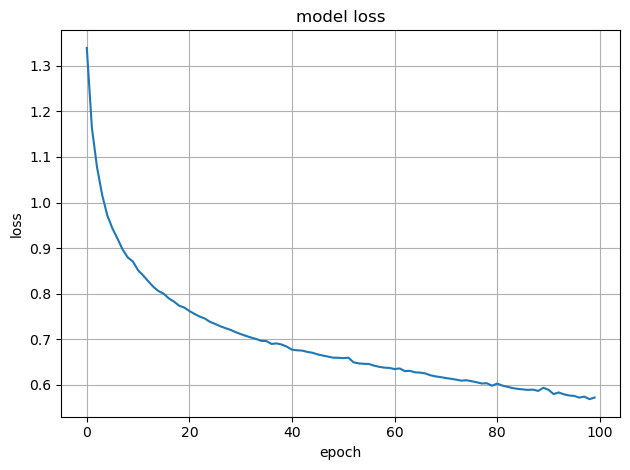

In [25]:
# summarize history for loss
plt.figure()
plt.grid()
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['Training', 'Validation'], loc='upper left')
plt.tight_layout()
# plt.savefig('autoencoder_learning_curve_loss.png', dpi=300)
plt.show()

In [26]:
test_loss, test_acc = compound_model.evaluate(x_test_scaled, disease_labels_test, verbose=2)

print('\nTest accuracy:', test_acc)

3/3 - 0s - loss: 0.8012 - accuracy: 0.5641 - 119ms/epoch - 40ms/step

Test accuracy: 0.5641025900840759


In [27]:
compound_model.predict(x_test_scaled.head(1))[0]

1/1 [==============================] - 0s 119ms/step


array([0.58691347, 0.39193138, 0.02115515], dtype=float32)

In [28]:
x_test_scaled.iloc[[0],:]

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.84188,0.930171,0.886737,0.835678,0.297964,0.668498,0.26667,0.278122,0.93352,...,0.339788,0.326732,0.0,0.862246,0.074473,0.0,0.498941,0.34992,0.0,0.0


In [52]:
compound_model.save("cd_clf")

INFO:tensorflow:Assets written to: cd_clf\assets
